# Desafio Kaggle: Titanic

- https://www.kaggle.com/c/titanic

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Base de dados

https://www.kaggle.com/competitions/titanic/data?select=gender_submission.csv

In [33]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

---

### Importando os arquivos

In [37]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
gender_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gender_submission.csv')

---

### Visualizando os arquivos importados

In [38]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [39]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [40]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [41]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [42]:
# Salvar PassengerId para auxiliar na criação do arquivo que será enviado ao Kaggle
passengerId = test['PassengerId']

# Criando um DF novo com o train e o test
titanic_df = train.append(test, ignore_index=True)

In [43]:
# Para auxiliar no momento separar o DF titanic_df em train e test
train_index = len(train)
test_index = len(titanic_df) - len(test)

In [44]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [45]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [46]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [47]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [48]:
# Criando o df onde iremos processar os modelos de ML

df = pd.DataFrame()

### Survived

In [49]:
titanic_df['Survived'].nunique()

2

In [50]:
titanic_df['Survived'].unique()

array([ 0.,  1., nan])

In [51]:
titanic_df['Survived'].isnull().sum()

418

In [52]:
titanic_df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

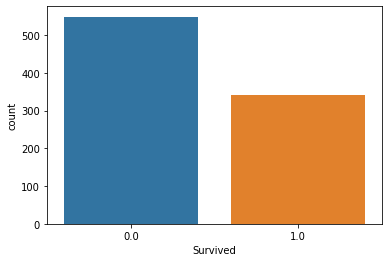

In [53]:
sns.countplot(data = titanic_df, x = 'Survived')

Quantidade de valores únicos: 2

Quais são os valores únicos: [ 0.  1. nan]

Quantidade de valores nulos: 418

Quantidade por opção: 
0.0    549
1.0    342
Name: Survived, dtype: int64


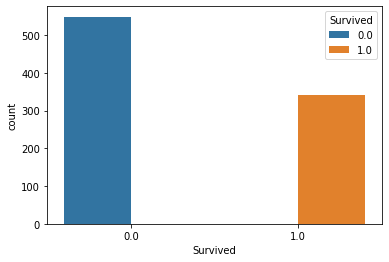

In [54]:
# Criando uma função para ajudar no momento de visualizar as informações de cada coluna

def titanic_func(data, column, count = True):
    print(f'Quantidade de valores únicos: {data[column].nunique()}')
    print(f'\nQuais são os valores únicos: {data[column].unique()}')
    print(f'\nQuantidade de valores nulos: {data[column].isnull().sum()}')
    print(f'\nQuantidade por opção: \n{data[column].value_counts()}')
    
    if count == True:
        sns.countplot(data = data, x = column, hue = 'Survived')
    else:
        sns.displot(data[column], kde = True)
    
    
titanic_func(titanic_df, 'Survived')

In [55]:
df['Survived'] = titanic_df['Survived']

In [56]:
df

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1304,NaN
1305,NaN
1306,NaN
1307,NaN


### Pclass

Quantidade de valores únicos: 3

Quais são os valores únicos: [3 1 2]

Quantidade de valores nulos: 0

Quantidade por opção: 
3    709
1    323
2    277
Name: Pclass, dtype: int64


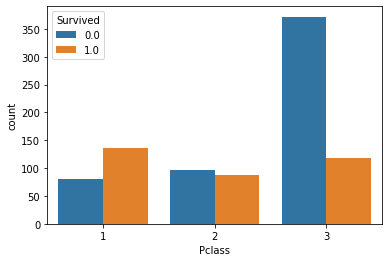

In [57]:
titanic_func(titanic_df, 'Pclass')

In [58]:
df['Pclass'] = titanic_df['Pclass']
df.head()

,Survived,Pclass
0,0.0,3
1,1.0,1
2,1.0,3
3,1.0,1
4,0.0,3


### Sex

In [59]:
titanic_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [60]:
# titanic_df['Sex'].map({'female': 1, 'male': 0})
titanic_df['Sex'] = titanic_df['Sex'].replace(['female', 'male'], [1, 0])

Quantidade de valores únicos: 2

Quais são os valores únicos: [0 1]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    843
1    466
Name: Sex, dtype: int64


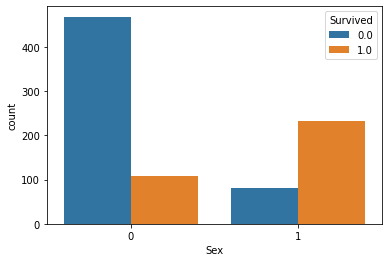

In [61]:
titanic_func(titanic_df, 'Sex')

In [62]:
df['Sex'] = titanic_df['Sex']
df.head()

,Survived,Pclass,Sex
0,0.0,3,0
1,1.0,1,1
2,1.0,3,1
3,1.0,1,1
4,0.0,3,0


### Age

Quantidade de valores únicos: 98

Quais são os valores únicos: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]

Quantidade de valores nulos: 263

Quantidade por opção: 
24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
        ..
23.5     1
70.5     1
55.5     1
20.5     1
38.5     1
Name: Age, Length: 98, dtype: int64


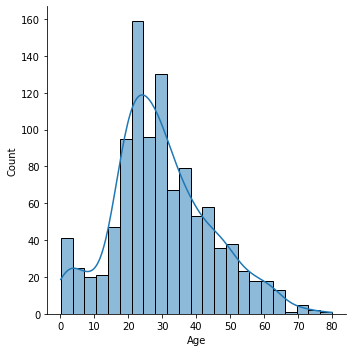

In [63]:
titanic_func(titanic_df, 'Age', False)

In [64]:
titanic_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.408106,0.060832,0.018322,-0.558629
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.063645,0.109609,0.213125,0.185523
Age,0.028814,-0.077221,-0.408106,-0.063645,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,0.213125,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.185523,0.178740,0.160238,0.221539,1.000000


In [65]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].mean()

39.15992957746479

In [66]:
titanic_df[titanic_df['Pclass'] == 2]['Age'].mean()

29.506704980842912

In [67]:
titanic_df[titanic_df['Pclass'] == 3]['Age'].mean()

24.81636726546906

In [68]:
for i in sorted(titanic_df['Pclass'].unique()):
    print(f"Pessoas da {i}ª classe tem a média de idade de: {titanic_df[titanic_df['Pclass'] == i]['Age'].mean():.0f} anos.")

Pessoas da 1ª classe tem a média de idade de: 39 anos.
Pessoas da 2ª classe tem a média de idade de: 30 anos.
Pessoas da 3ª classe tem a média de idade de: 25 anos.


In [69]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].isnull().sum()

39

In [70]:
titanic_df['Age'].isnull().sum()

263

In [71]:
count = 0
for i in titanic_df.index:
    
    if pd.isnull(titanic_df['Age'][i]):
        
        if titanic_df['Pclass'][i] == 1:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 1]['Age'].mean(), 0)
            
        elif titanic_df['Pclass'][i] == 2:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean(), 0)
            
        elif titanic_df['Pclass'][i] == 3:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
            
    else:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [72]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].isnull().sum()

0

In [73]:
titanic_df['Age'].isnull().sum()

0

In [74]:
titanic_df['Age']

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    25.0
Name: Age, Length: 1309, dtype: float64

In [75]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


In [76]:
df['Age'] = titanic_df['Age']
df.head()

,Survived,Pclass,Sex,Age
0,0.0,3,0,22.0
1,1.0,1,1,38.0
2,1.0,3,1,26.0
3,1.0,1,1,35.0
4,0.0,3,0,35.0


### SibSp

Quantidade de valores únicos: 7

Quais são os valores únicos: [1 0 3 4 2 5 8]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64


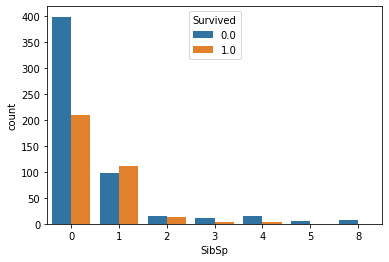

In [77]:
titanic_func(titanic_df, 'SibSp')

In [78]:
df['SibSp'] = titanic_df['SibSp']
df.head()

,Survived,Pclass,Sex,Age,SibSp
0,0.0,3,0,22.0,1
1,1.0,1,1,38.0,1
2,1.0,3,1,26.0,0
3,1.0,1,1,35.0,1
4,0.0,3,0,35.0,0


### Parch

Quantidade de valores únicos: 8

Quais são os valores únicos: [0 1 2 5 3 4 6 9]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64


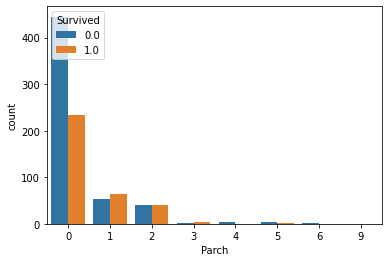

In [79]:
titanic_func(titanic_df, 'Parch')

In [80]:
df['Parch'] = titanic_df['Parch']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0.0,3,0,22.0,1,0
1,1.0,1,1,38.0,1,0
2,1.0,3,1,26.0,0,0
3,1.0,1,1,35.0,1,0
4,0.0,3,0,35.0,0,0


### Criando coluna - FamilySize 

In [81]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1 

In [82]:
df['FamilySize'] = titanic_df['FamilySize']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize
0,0.0,3,0,22.0,1,0,2
1,1.0,1,1,38.0,1,0,2
2,1.0,3,1,26.0,0,0,1
3,1.0,1,1,35.0,1,0,2
4,0.0,3,0,35.0,0,0,1


### Fare

Quantidade de valores únicos: 281

Quais são os valores únicos: [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.3125  61.3792   7.7333  69.55    16.1
  15.75    20.525   55.      25.925   33.5     30.6958  25.4667  28.7125
   0.      1

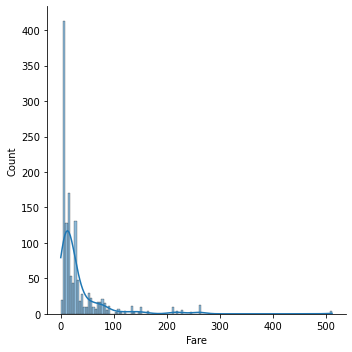

In [83]:
titanic_func(titanic_df, 'Fare', False)

In [84]:
titanic_df[titanic_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,1


In [85]:
titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean()

13.302888700564973

In [86]:
titanic_df['Fare'].fillna(titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean(), inplace = True)

In [87]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
FamilySize        0
dtype: int64

In [88]:
df['Fare'] = titanic_df['Fare']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare
0,0.0,3,0,22.0,1,0,2,7.2500
1,1.0,1,1,38.0,1,0,2,71.2833
2,1.0,3,1,26.0,0,0,1,7.9250
3,1.0,1,1,35.0,1,0,2,53.1000
4,0.0,3,0,35.0,0,0,1,8.0500


### Cabin

In [89]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2


In [90]:
titanic_df['Cabin'].isnull().sum()

1014

In [91]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Embarked

Quantidade de valores únicos: 3

Quais são os valores únicos: ['S' 'C' 'Q' nan]

Quantidade de valores nulos: 2

Quantidade por opção: 
S    914
C    270
Q    123
Name: Embarked, dtype: int64


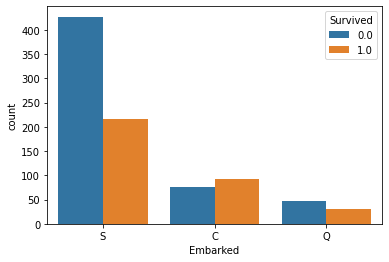

In [92]:
titanic_func(titanic_df, 'Embarked')

In [93]:
titanic_df[titanic_df['Embarked'] == "S"]['Survived'].mean()

0.33695652173913043

In [94]:
titanic_df[titanic_df['Embarked'] == "S"]['Pclass'].mean()

2.3479212253829322

In [95]:
titanic_df[titanic_df['Embarked'] == "C"]['Survived'].mean()

0.5535714285714286

In [96]:
titanic_df[titanic_df['Embarked'] == "C"]['Pclass'].mean()

1.8518518518518519

In [97]:
titanic_df[titanic_df['Embarked'] == "Q"]['Survived'].mean()

0.38961038961038963

In [98]:
titanic_df[titanic_df['Embarked'] == "Q"]['Pclass'].mean()

2.894308943089431

In [99]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1


In [100]:
titanic_df['Embarked'].fillna('C', inplace = True)

In [101]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
dtype: int64

In [102]:
df['Embarked'] = titanic_df['Embarked']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked
0,0.0,3,0,22.0,1,0,2,7.2500,S
1,1.0,1,1,38.0,1,0,2,71.2833,C
2,1.0,3,1,26.0,0,0,1,7.9250,S
3,1.0,1,1,35.0,1,0,2,53.1000,S
4,0.0,3,0,35.0,0,0,1,8.0500,S


### Name

In [103]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1


In [104]:
titanic_df['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [105]:
# [titanic_df['Name'][n].split(',')[1].split('.')[0].strip() for n in titanic_df.index]
titanic_df['Title'] = titanic_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [106]:
titanic_df['Title'].nunique()

18

In [107]:
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [108]:
titanic_df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [109]:
titanic_df['Title'] = [n if n in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Person' for n in titanic_df['Title']]

In [110]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,Person
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,1,Mr


In [111]:
df['Title'] = titanic_df['Title']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr


Quantidade de valores únicos: 5

Quais são os valores únicos: ['Mr' 'Mrs' 'Miss' 'Master' 'Person']

Quantidade de valores nulos: 0

Quantidade por opção: 
Mr        757
Miss      260
Mrs       197
Master     61
Person     34
Name: Title, dtype: int64


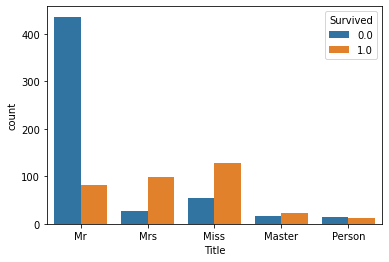

In [112]:
titanic_func(titanic_df, 'Title')

In [113]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
Title             0
dtype: int64

---

In [114]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1,8.0500,S,Mr
1305,NaN,1,1,39.0,0,0,1,108.9000,C,Person
1306,NaN,3,0,38.5,0,0,1,7.2500,S,Mr
1307,NaN,3,0,25.0,0,0,1,8.0500,S,Mr


In [115]:
pclass = pd.get_dummies(df['Pclass'], prefix = "Pclass", drop_first = True)
title = pd.get_dummies(df['Title'], prefix = 'Title', drop_first = True)
embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked', drop_first = True)

In [116]:
titanic_completo = pd.concat([df, pclass, title, embarked], axis = 1)

In [117]:
titanic_completo.drop(['Pclass', 'Title', 'Embarked'], axis=1, inplace=True)

In [118]:
titanic_completo

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [119]:
train = titanic_completo[:train_index].copy()
test = titanic_completo[test_index:].copy()

In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Sex           891 non-null    int64  
 2   Age           891 non-null    float64
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   FamilySize    891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Pclass_2      891 non-null    uint8  
 8   Pclass_3      891 non-null    uint8  
 9   Title_Miss    891 non-null    uint8  
 10  Title_Mr      891 non-null    uint8  
 11  Title_Mrs     891 non-null    uint8  
 12  Title_Person  891 non-null    uint8  
 13  Embarked_Q    891 non-null    uint8  
 14  Embarked_S    891 non-null    uint8  
dtypes: float64(3), int64(4), uint8(8)
memory usage: 55.8 KB


In [121]:
train['Survived'] = train['Survived'].astype(int)

In [122]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [123]:
X_test = test.drop('Survived', axis = 1)

---

In [124]:
# Função que processa o Algoritmo e retorna a acurácia

def func_acuracia(algoritmo, X_train, y_train, vc):
    modelo = algoritmo.fit(X_train, y_train)
    acuracia = round(modelo.score(X_train, y_train) * 100, 2)
    
    train_pred = model_selection.cross_val_predict(algoritmo, X_train, y_train, cv = vc, n_jobs = -1)    
    acuracia_vc = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return acuracia, acuracia_vc

### Random Forest

In [125]:
acc_rf, acc_vc_rf = func_acuracia(RandomForestClassifier(), X, y, 10)

print(f"Acurácia: {acc_rf}")
print(f"Acurácia Validação Cruzada: {acc_vc_rf}")

Acurácia: 98.32
Acurácia Validação Cruzada: 80.7


### Logistic regression

In [126]:
acc_log, acc_vc_log = func_acuracia(LogisticRegression(max_iter=1000), X, y, 10)

print(f"Acurácia: {acc_log}")
print(f"Acurácia Validação Cruzada: {acc_vc_log}")

Acurácia: 82.94
Acurácia Validação Cruzada: 82.49


### K-Nearest Neighbours

In [127]:
acc_knn, acc_vc_knn = func_acuracia(KNeighborsClassifier(), X, y, 10)

print(f"Acurácia: {acc_knn}")
print(f"Acurácia Validação Cruzada: {acc_vc_knn}")

Acurácia: 80.58
Acurácia Validação Cruzada: 72.5


### Gaussian Naive Bayes

In [128]:
acc_gaussian, acc_vc_gaussian = func_acuracia(GaussianNB(), X, y, 10)

print(f"Acurácia: {acc_gaussian}")
print(f"Acurácia Validação Cruzada: {acc_vc_gaussian}")

Acurácia: 78.79
Acurácia Validação Cruzada: 78.56


### Linear Support Vector Machines (SVC)

In [129]:
acc_linear_svc, acc_vc_linear_svc = func_acuracia(LinearSVC(dual=False), X, y, 10)

print(f"Acurácia: {acc_linear_svc}")
print(f"Acurácia Validação Cruzada: {acc_vc_linear_svc}")

Acurácia: 83.28
Acurácia Validação Cruzada: 82.72


### Stochastic Gradient Descent

In [130]:
acc_sgd, acc_vc_sgd = func_acuracia(SGDClassifier(), X, y, 10)

print(f"Acurácia: {acc_sgd}")
print(f"Acurácia Validação Cruzada: {acc_vc_sgd}")

Acurácia: 71.27
Acurácia Validação Cruzada: 74.64


### Decision Tree Classifier

In [131]:
acc_dt, acc_vc_dt = func_acuracia(DecisionTreeClassifier(), X, y, 10)

print(f"Acurácia: {acc_dt}")
print(f"Acurácia Validação Cruzada: {acc_vc_dt}")

Acurácia: 98.32
Acurácia Validação Cruzada: 79.91


### Gradient Boost Trees

In [132]:
acc_gbt, acc_vc_gbt = func_acuracia(GradientBoostingClassifier(), X, y, 10)

print(f"Acurácia: {acc_gbt}")
print(f"Acurácia Validação Cruzada: {acc_vc_gbt}")

Acurácia: 89.67
Acurácia Validação Cruzada: 83.05


---

### Artigo no Medium sobre como alterar os parâmetros

 - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
 - https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f
 - https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/cross-validation.html (PT-BR)

In [133]:
params = dict(     
    max_depth = [n for n in range(1, 5)],     
    min_samples_split = [n for n in range(2, 6)], 
    min_samples_leaf = [n for n in range(2, 6)],     
    n_estimators = [n for n in range(10, 50, 10)],
)

In [134]:
gbc = GradientBoostingClassifier()

In [135]:
gbc_cv = GridSearchCV(estimator = gbc, param_grid = params, cv = 10) 
gbc_cv.fit(X, y)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40]})

In [136]:
print(f"Melhor pontuação: {gbc_cv.best_score_}")
print(f"Melhores parâmetros: {gbc_cv.best_estimator_}")

Melhor pontuação: 0.8485143570536829
Melhores parâmetros: GradientBoostingClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                           n_estimators=30)


In [137]:
gradientBoostingClassifier_pred = gbc_cv.predict(X_test)

In [138]:
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': gradientBoostingClassifier_pred})
# save to csv
kaggle.to_csv('./titanic_gradient_boosting_pred.csv', index=False)

---